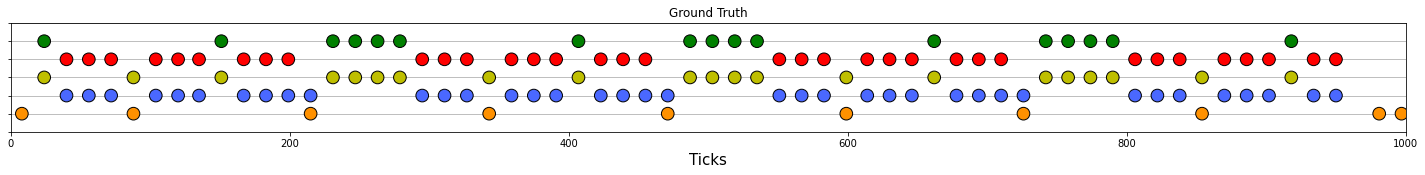

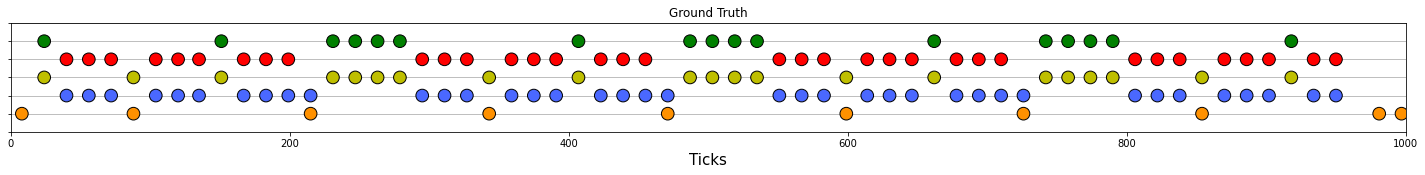

In [5]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
from tensor_hero.preprocessing.audio import ninos, onset_select
from tensor_hero.preprocessing.chart import chart2tensor
from tensor_hero.preprocessing.data import __remove_release_keys, __remove_modifiers
from tensor_hero.visualization import plot_chart
import librosa

song_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Anberlin - The Feel Good Drag'

notes_array = chart2tensor(song_path / 'notes.chart')
notes_array = __remove_modifiers(__remove_release_keys(notes_array))

audio, sr = librosa.load(str(song_path / 'other.wav'))
plot_chart(notes_array[1000:2000])

In [ ]:
song_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Anberlin - The Feel Good Drag'

notes_array = chart2tensor(song_path / 'notes.chart')
notes_array = __remove_modifiers(__remove_release_keys(notes_array))

audio, sr = librosa.load(str(song_path / 'other.wav'))
plot_chart(notes_array[1000:2000])

In [78]:
import math

def ninos(audio, sr, gamma=0.94):
    '''Calculates Normalized Identifying Note Onsets based on Spectral Sparsity (NINOS)
    over time for audio.
   
    Implementation as described in 
        https://www.eurasip.org/Proceedings/Eusipco/Eusipco2016/papers/1570256369.pdf 
        
    Each time bin in the returned frame corresponds to approx 4.6ms of audio data.

    Args:
        audio (1D numpy array): Raw audio samples
        sr (int): sample rate
        gamma (float in (0,1]): Proportion of frequency bins to keep
    
    Returns:
        ninos (1D numpy array): Normalized inverse-sparsity measure
        J (int): Number of retained frequency bins
        hop_length (int): Hop length used to compute spectrogram
        
    '''
    # Define spectrogram parameters
    if sr == 22050:
        n_fft = 1024
        hop_length = 102
    elif sr == 44100:
        n_fft = 2048
        hop_length = 205
    else:
        raise ValueError(f'ERROR: sr = {sr}, sr must be either 22050 or 44100')    

    # Compute spectrogram
    spec = np.abs(librosa.stft(audio, n_fft, hop_length))
    
    # Order by magnitude within each time bin
    spec = np.sort(spec, axis=0)
    
    # Remove the highest energy frames, cut down by factor of gamma
    J = math.floor(spec.shape[0]*gamma)
    spec = spec[:J,:]
    
    # Compute squared l2 norm and l4 norm of spec along time axis
    l2_squared = np.square(np.linalg.norm(spec, ord=2, axis=0))
    l4 = np.linalg.norm(spec, ord=4, axis=0)
    
    # Convert to NINOS
    ninos = l2_squared / ((J**(1/4))*l4)

    return ninos, J, hop_length

odf, J, hop_len = ninos(audio[sr*10:sr*20], sr)
print(f'hop length : {hop_len}')

hop length : 102


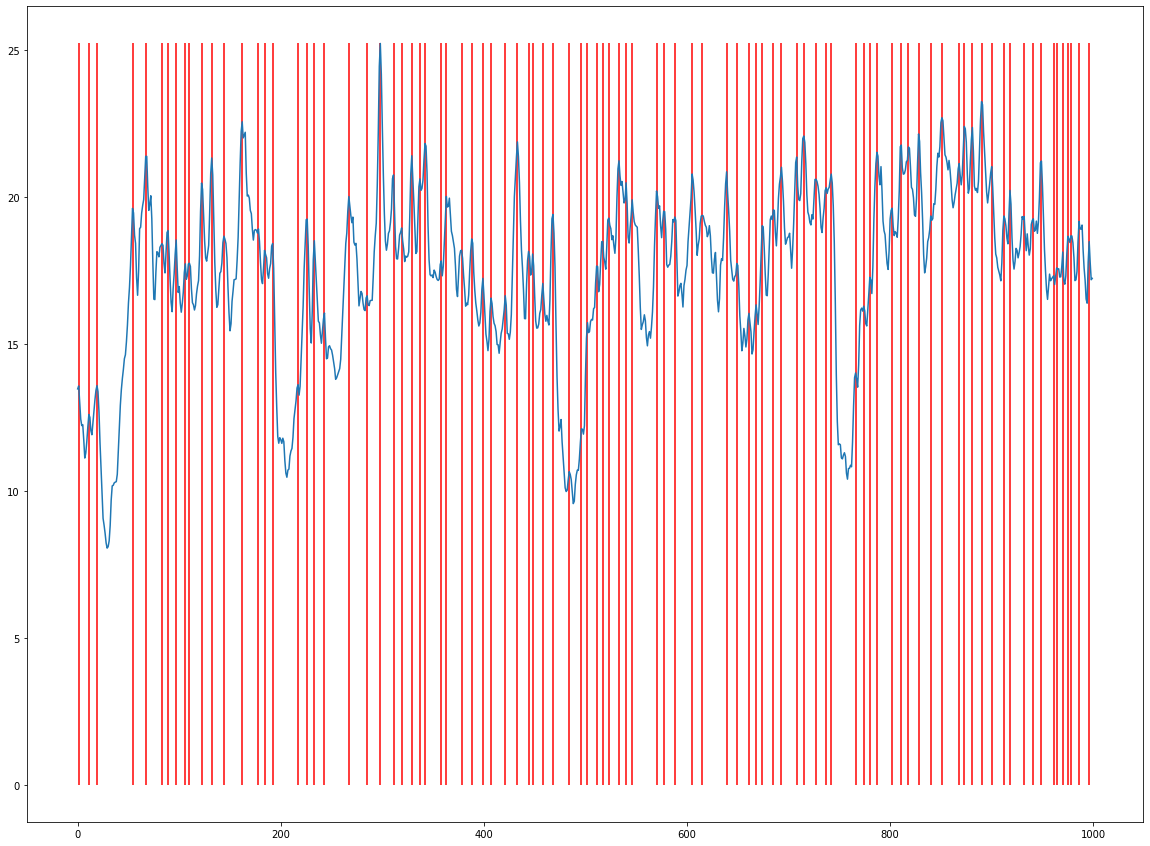

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def squeeze_idx(idx, min, max):
    '''Helper function that ensures the indices of the windows stays between 0 and max.
   
    Args:
        idx (int): Candidate index
        min (int): Minimum value to be assigned (typically 0)
        max (int): Maximum value to be assigned (typically len(arr) - 1)
    
    Returns:
        idx (int): Correct index to be used for window bounds
        
    '''
    if idx < min:
        return min
    elif idx > max:
        return max
    else:
        return idx

def onset_select(odf_arr, w1=3, w2=3, w3=7, w4=1, w5=0, delta=0, plot=False):
    '''Implements peak-picking for the results of ninos ODF data. 
   
    Implementation as described in 
        https://ismir2012.ismir.net/event/papers/049_ISMIR_2012.pdf 
        
    Args:
        odf_arr (1D numpy array): Values of ninos ODF function
        w1 (int): Hyperparameter for left boundary of window for condition 1
        w2 (int): Hyperparameter for right boundary of window for condition 1
        w3 (int): Hyperparameter for left boundary of window for condition 2
        w4 (int): Hyperparameter for right boundary of window for condition 2
        w5 (int): Hyperparameter for onset threshold (how many windows to use as buffer before selecting a new onset)
        delta (float in [0,infinity)): Threshold for condition 2
        plot (bool): Whether or not to plot onsets overlaid on ninos data
    
    Returns:
        onsets (1D numpy array): Frame indices for onsets
        
    '''
    onsets = []
    plt_onsets = []

    for frame in range(len(odf_arr)):
        # Determine whether candidate frame is a local maximum
        idx1 = squeeze_idx(frame-w1, 0, len(odf_arr)-1)
        idx2 = squeeze_idx(frame+w2, 0, len(odf_arr)-1)
        # print(f'idx1 : {idx1}')
        # print(f'idx2 : {idx2}')
        # print(f'odf_arr[idx1:idx2] : {odf_arr[idx1:idx2]}')
        # print(f'np.argmax(odf_arr[idx1:idx2][0]) : {np.argmax(odf_arr[idx1:idx2][0])}')
        max_frame = idx1 + np.argmax(odf_arr[idx1:idx2])
        cond1 = frame == max_frame
        # Determine whether candidate frame surpasses local average by delta
        idx1 = squeeze_idx(frame-w3, 0, len(odf_arr)-1)
        idx2 = squeeze_idx(frame+w4, 0, len(odf_arr)-1)
        mean_frame = np.mean(odf_arr[idx1:idx2]) + delta
        cond2 = odf_arr[frame] >= mean_frame
        # True by default if onsets is empty
        cond3 = True
        # print(f'cond1 : {cond1}')
        # print(f'cond2 : {cond2}')
        # print(f'cond3 : {cond3}')
        # print(f'frame : {frame}')

        if len(onsets) > 0:
            # Determine whether candidate frame surpasses a threshold since last onset
            cond3 = frame - onsets[len(onsets) - 1] > w5
        if cond1 and cond2 and cond3:
            onsets.append(frame)
            
    onsets = np.array(onsets)
    if plot:
        plt.figure(figsize=(20, 15))
        plt.plot(odf_arr[:1000])
        plt.vlines(onsets[np.where(onsets < 1000)[0]], ymin=0, ymax=np.max(odf_arr[:1000]), colors=['red'])
        plt.show()
    return onsets
    
onsets = onset_select(odf, delta=0, plot=True)

In [73]:
def onset_frames_to_time(onsets, sr, hop_len):
    time_per_frame = hop_len/sr
    return [x*time_per_frame for x in onsets]

onset_times = onset_frames_to_time(onsets, sr, hop_len)

In [74]:
ch_onsets = np.where(notes_array[1000:2000] > 0)[0]
print(ch_onsets)

[  8  24  40  56  72  88 104 120 135 151 167 183 199 215 231 247 263 279
 295 311 327 343 359 375 391 407 423 439 455 471 487 503 519 535 551 567
 583 599 614 630 646 662 678 694 710 726 742 758 774 790 806 822 838 854
 870 886 902 918 934 950 981 997]


In [75]:
print(len(ch_onsets))
print(len(onset_times))

62
205


In [76]:
def onset_times_to_bins(onset_times):
    onset_times = [round(x*100) for x in onset_times]
    return onset_times

onset_time_bins = onset_times_to_bins(onset_times)
print(onset_time_bins)

[0, 5, 9, 25, 31, 38, 41, 45, 49, 51, 56, 61, 67, 75, 82, 85, 89, 100, 105, 108, 112, 124, 132, 138, 144, 148, 152, 156, 158, 166, 168, 175, 179, 185, 188, 195, 200, 205, 207, 212, 216, 224, 229, 232, 236, 239, 242, 247, 250, 253, 264, 267, 272, 280, 284, 296, 300, 306, 309, 312, 317, 321, 328, 331, 336, 341, 343, 354, 358, 361, 364, 371, 375, 378, 383, 389, 394, 402, 404, 408, 412, 416, 422, 425, 431, 435, 439, 445, 446, 449, 451, 452, 456, 461, 463, 467, 469, 471, 481, 486, 488, 493, 499, 503, 510, 519, 521, 528, 533, 542, 547, 551, 555, 559, 561, 567, 571, 578, 584, 590, 593, 596, 599, 607, 614, 619, 622, 625, 631, 647, 649, 656, 658, 663, 668, 672, 680, 682, 689, 692, 694, 700, 704, 708, 711, 718, 723, 726, 734, 738, 742, 743, 749, 756, 760, 764, 767, 770, 776, 783, 786, 791, 795, 803, 805, 809, 813, 816, 822, 824, 829, 834, 840, 848, 854, 864, 871, 875, 882, 885, 887, 895, 897, 904, 911, 915, 918, 925, 927, 930, 933, 937, 944, 947, 952, 955, 959, 962, 966, 970, 977, 988, 991, 994,

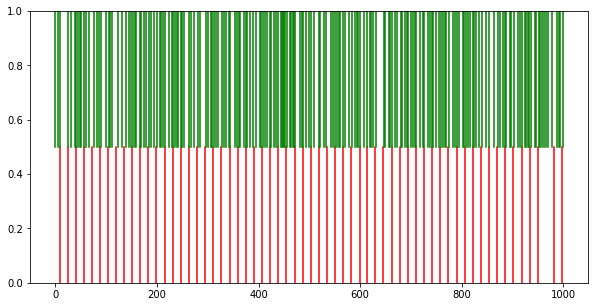

In [77]:
plt.figure(figsize=(10,5))
for o in ch_onsets:
    plt.axvline(x=o, ymin=0, ymax=0.5, color='r')
for o in onset_time_bins:
    plt.axvline(x=o, ymin=0.5, ymax=1, color='g')

In [104]:
from mir_eval.onset import f_measure
from tqdm import tqdm

def compare_onsets(audio, sr, notes_array, start, end,
                   w1=3, w2=3, w3=7, w4=1, w5=0, delta=0,
                   plot= False):
    
    # Measure onsets using spectral sparsity
    odf, _, hop_len = ninos(audio[sr*start:sr*end], sr)
    onsets = onset_select(odf, w1, w2, w3, w4, w5, delta, plot=False)
    onset_times = onset_frames_to_time(onsets, sr, hop_len)
    onset_time_bins = onset_times_to_bins(onset_times)

    # Get ground truth clone hero onsets
    ch_onsets = np.where(notes_array[start*100:end*100] > 0)[0]
    ch_onset_times = [x/100 for x in ch_onsets]
    
    # Compare with f_measure
    f1, _, _ = f_measure(np.array(ch_onset_times), np.array(onset_times))
    
    # plot
    if plot:
        plt.figure(figsize=(15,5))
        for o in ch_onsets:
            plt.axvline(x=o, ymin=0, ymax=0.5, color='r')
        for o in onset_time_bins:
            plt.axvline(x=o, ymin=0.5, ymax=1, color='g')
    
    return f1
        
f1 = compare_onsets(audio, sr, notes_array, 10, 20,
                    w2=10)

w_1 = [*range(1,11)]
w_2 = [*range(1,11)]
w_3 = [*range(1,11)]
w_4 = [*range(1,11)]
w_5 = [*range(1,11)]
_delta = np.arange(0, 3, step=0.1)
best_hyperparams = {
    'w1' : 0,
    'w2' : 0,
    'w3' : 0,
    'w4' : 0,
    'w5' : 0,
    'delta' : 0
}

best_f1 = 0
for w1 in tqdm(w_1, position=0, desc='w1', leave=False, colour='green', ncols=80):
    for w2 in tqdm(w_2, position=0, desc='w2', leave=False, colour='red', ncols=80):
        for w3 in tqdm(w_3, position=0, desc='w3', leave=False, colour='yellow', ncols=80):
            for w4 in w_4:
                for w5 in w_5:
                    for delta in _delta:
                        f1 = compare_onsets(audio, sr, notes_array, 10, 20,
                                            w1=w1, w2=w2, w3=w3, w4=w4, w5=w5, delta=delta)
                        if f1 > best_f1:
                            best_f1 = f1
                            best_hyperparams['w1'] = w1
                            best_hyperparams['w2'] = w2
                            best_hyperparams['w3'] = w3
                            best_hyperparams['w4'] = w4
                            best_hyperparams['w5'] = w5
                            best_hyperparams['delta'] = delta

print(f'best f1 : {best_f1}')
print(f'best hyperparams: {best_hyperparams}')

    


w3:   0%|                                                | 0/10 [00:00<?, ?it/s]C:\Users\ewais\AppData\Local\Programs\Python\Python38\lib\site-packages\mir_eval\onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


KeyboardInterrupt: 

In [102]:
best_hyperparams

{'w1': 1, 'w2': 1, 'w3': 1, 'w4': 8, 'w5': 10, 'delta': 1.0}